In [1]:
from eda_imports import *

import pysam
from tqdm import tqdm

import kleat.misc.settings as S
import kleat.misc.utils as U
from kleat.misc.apautils import calc_genome_offset
from kleat.evidence import bridge

from kleat.visaln import visaln

seaborn not found


In [25]:
adf = pd.read_csv('../../kleat/output.csv')

/projects/btl2/zxue/kleat/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
adf.evidence_type.value_counts()

blank            46355
suffix           411  
bridge           306  
link             131  
blank|suffix     16   
blank|bridge     12   
bridge|suffix    9    
blank|link       1    
Name: evidence_type, dtype: int64

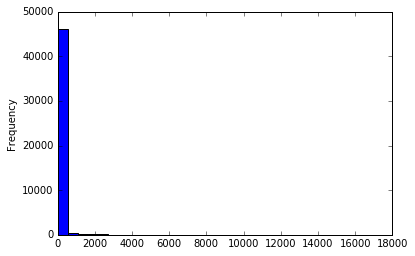

In [28]:
adf.max_contig_len.plot.hist(bins=30)

In [7]:
# DATA_DIR='/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-TCGA-analysis-scripts/benchmark-kleat.bk/UHR/C1/tasrkleat-results'
DATA_DIR='../../kleat/'

c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/c2g.bam'))
r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/r2c_sorted.bam'))

In [9]:
# contig_name = 'A0.R100625'
contig_name = 'E3.L.51'

In [10]:
for contig in c2g_bam:
    if contig.query_name == contig_name:
        if contig.reference_name == 'chrM' and contig.is_reverse:
            print(contig.cigarstring)
            break

560H119M1I65M


In [11]:
contig.is_reverse

True

In [12]:
contig.reference_start

183

In [13]:
reads = r2c_bam.fetch(contig.query_name)
bdg_read_info = []
for rd in reads:
    if bridge.is_a_bridge_read(rd):
        if contig.is_reverse:
            contig_len = contig.infer_query_length(always=True)
            bdg_read_info.append([
                contig_len - rd.reference_end,
                contig_len - rd.reference_start,
                f'rev({rd.cigarstring})',
                tuple(reversed(rd.cigartuples))
            ])
        else:
            raise NotImplementedError

In [14]:
df_bdg_read = pd.DataFrame(bdg_read_info, columns=['reference_start', 'reference_end', 'cigarstring', 'cigartuples'])
df_bdg_read = df_bdg_read.sort_values('reference_start').reset_index(drop=True)

In [15]:
df_bdg_read.shape

(32, 4)

In [16]:
df_bdg_read.iloc[7:].head()

,reference_start,reference_end,cigarstring,cigartuples
7,278,352,rev(1S74M),"((0, 74), (4, 1))"
8,278,352,rev(1S74M),"((0, 74), (4, 1))"
9,284,358,rev(1S74M),"((0, 74), (4, 1))"
10,284,358,rev(1S74M),"((0, 74), (4, 1))"
11,284,358,rev(1S74M),"((0, 74), (4, 1))"


In [17]:
contig_sr = pd.Series(
    [contig.reference_start, contig.reference_end, contig.cigarstring, contig.cigartuples], 
    index=['reference_start', 'reference_end', 'cigarstring', 'cigartuples']
)

In [18]:
contig_sr.to_frame().T

,reference_start,reference_end,cigarstring,cigartuples
0,183,367,560H119M1I65M,"[(5, 560), (0, 119), (1, 1), (0, 65)]"


In [19]:
# contig span
contig_sr.reference_end - contig_sr.reference_start

184

In [20]:
predicted_clv = -345

In [21]:
num_skips = visaln.calc_num_skips(contig)
df_xlims = visaln.calc_xlim_pairs(contig, predicted_clv)

In [23]:
num_skips

0

-378 - 368, covering clv False


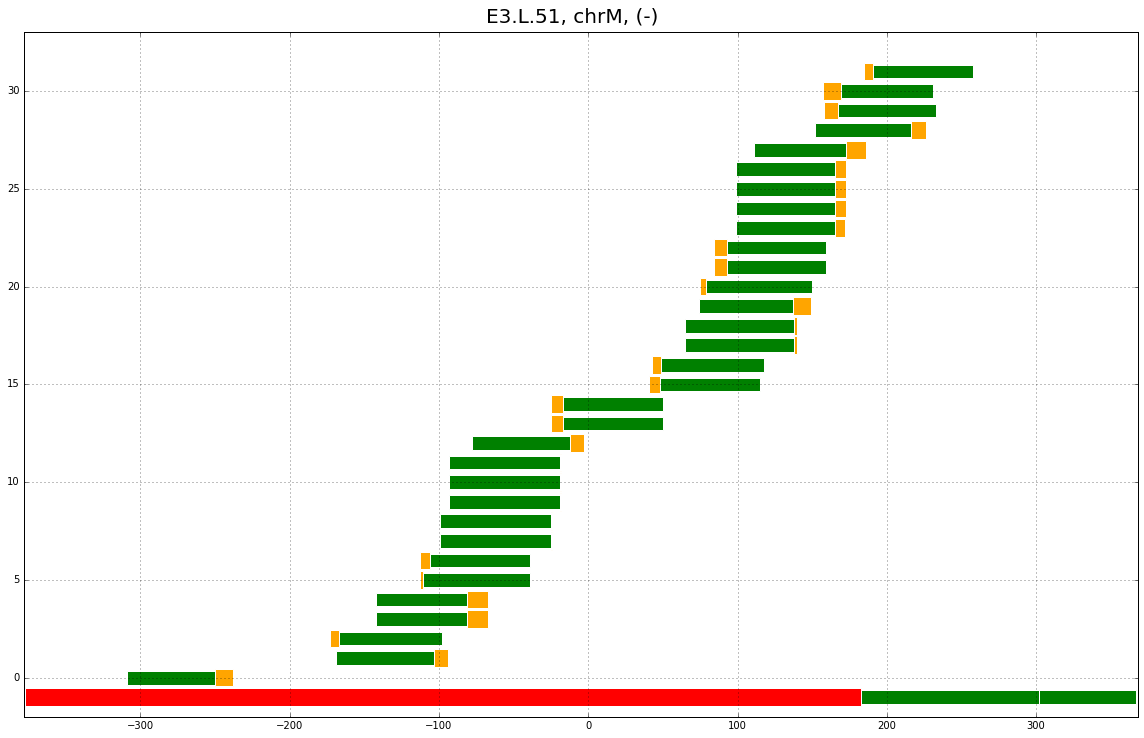

In [24]:
num_subplots = num_skips + 1
fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, 10), sharey=True, gridspec_kw = {'width_ratios':df_xlims.span})
if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
#         print(cx, end=', ')
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    clv = 204489253  # predicted
    ax.plot([clv, clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    ax.grid()
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.reference_name}, ({strand})', fontsize=20, y =1.02)
plt.tight_layout()